In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt

train_data = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

test_data = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

BATCH_SIZE = 100
LR_SCSG = 0.1

EPOCH = 20
LARGE_BATCH_NUMBER=25
INNER_LOOPS = 10

# Setup DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 10))
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 28 * 28)
        x = self.model(inputs)
        return F.log_softmax(x,dim=1)
    
    def partial_grad(self, inputs, targets):
        """
        Function to compute the stochastic gradient
        args : input, loss_function
        return : loss
        """
        outputs = self.forward(inputs)
        # compute the partial loss
        loss = F.nll_loss(outputs, targets)

        # compute gradient
        loss.backward()
        return loss.detach()
    
    def calculate_loss_grad(self, dataset, large_batch_num):
        """
        Function to compute the large-batch loss and the large-batch gradient
        args : dataset, loss function, number of samples to be calculated
        return : total_loss, full_grad_norm
        """

        total_loss = 0.0

        for idx, data in enumerate(dataset):
            # only calculate the sub-sampled large batch
            if idx > large_batch_num - 1:
                break
            # load input
            inputs, targets = data
            inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

            # calculate loss
            total_loss += self.partial_grad(inputs, targets)
            
        total_loss /= large_batch_num

        return total_loss

In [3]:
def calculate_grad_variance(net, train_loader, large_batch_num):
    net_grads = []
    for p_net in net.parameters():
        net_grads.append(p_net.grad.data)
    clone_net = copy.deepcopy(net)
    _ = clone_net.calculate_loss_grad(train_loader, large_batch_num)

    clone_net_grad = []
    for p_net in clone_net.parameters():
        clone_net_grad.append(p_net.grad.data/large_batch_num)
    del clone_net
    
    variance = 0.0
    for g1, g2 in zip(net_grads, clone_net_grad):
        variance += (g1-g2).norm(2) ** 2
    variance = torch.sqrt(variance)
    return variance

In [4]:
def sarah_step(net, optimizer, train_loader, test_loader, inner_iter_num):
    """
    Function to updated weights with a SARAH backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    large_batch_num = LARGE_BATCH_NUMBER
    batch_size = BATCH_SIZE
    
    # record previous net full gradient
    pre_net_full = copy.deepcopy(net)
    # record previous net mini batch gradient
    pre_net_mini = copy.deepcopy(net)

    # Compute full grad
    optimizer.zero_grad()
    _ = net.calculate_loss_grad(train_loader, large_batch_num)

    for p_net in net.parameters():
        p_net.grad.data *= (1.0 / large_batch_num)
        
    optimizer.step()
        
    running_loss = []
    iter_num = 0.0
    grad_variances = []
    # Run over the train_loader
    for batch_id, batch_data in enumerate(train_loader):

        if batch_id > inner_iter_num - 1:
            break
        
        # record previous net full gradient
        for p_net, p_full in zip(net.parameters(), pre_net_full.parameters()):
            p_full.grad = copy.deepcopy(p_net.grad)
        
        # get the input and label
        inputs, targets = batch_data

        # wrap data and target into variable
        inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

        # compute previous stochastic gradient
        pre_net_mini.zero_grad()
        # take backward
        _ = pre_net_mini.partial_grad(inputs, targets)

        # compute current stochastic gradient
        optimizer.zero_grad()
        current_loss = net.partial_grad(inputs, targets)

        # take SCSG gradient step
        for p_net, p_mini, p_full in zip(net.parameters(), pre_net_mini.parameters(), pre_net_full.parameters()):
            p_net.grad.data = p_net.grad.data + p_full.grad.data - p_mini.grad.data
        
        grad_variances += [calculate_grad_variance(net, train_loader, LARGE_BATCH_NUMBER)]
        
        # record previous net mini batch gradient
        for p_mini, p_net in zip(pre_net_mini.parameters(), net.parameters()):
            p_mini.data = copy.deepcopy(p_net.data)
        
        optimizer.step()

        # print statistics
        running_loss += [current_loss.cpu().detach()]
        iter_num += 1.0

    # calculate training loss
    train_loss = np.mean(running_loss)

    # calculate test loss
    net.zero_grad()
    test_loss = net.calculate_loss_grad(test_loader, len(test_loader)/batch_size)

    return train_loss, test_loss, running_loss, grad_variances

In [5]:
def sgd_step(net, optimizer, train_loader, test_loader, inner_iter_num):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    batch_size = BATCH_SIZE

    running_loss = []
    iter_num = 0.0
    grad_variances = []
    
    # Run over the train_loader
    for batch_id, batch_data in enumerate(train_loader):

        if batch_id > inner_iter_num - 1:
            break

        # get the input and label
        inputs, targets = batch_data

        # wrap data and target into variable
        inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

        # compute current stochastic gradient
        optimizer.zero_grad()

        outputs = net(inputs)
        current_loss = F.nll_loss(outputs, targets)
        current_loss.backward()
        
        grad_variances.append(calculate_grad_variance(net, train_loader, LARGE_BATCH_NUMBER))
        optimizer.step()

        # print statistics
        running_loss += [current_loss.cpu().detach()]
        iter_num += 1.0

    # calculate training loss
    train_loss = np.mean(running_loss)

    # calculate test loss
    net.zero_grad()
    test_loss = net.calculate_loss_grad(test_loader, len(test_loader)/batch_size)

    return train_loss, test_loss, running_loss, grad_variances

In [6]:
net = Model().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=LR_SCSG)
# optimizer = torch.optim.Adam(net.parameters())

sarah_loss_train = []
sarah_loss_test  = []
sarah_loss_all = []
sarah_grad_variances = []
# training
for epoch in range(EPOCH):
    inner_iter_num = INNER_LOOPS #np.random.geometric(1.0/(LARGE_BATCH_NUMBER + 1.0))
    # take one epoch scsg step
    cur_train_loss, cur_test_loss, cur_loss_all, cur_grad_variances\
        = sarah_step(net, optimizer, train_loader, test_loader, inner_iter_num)
    sarah_loss_train.append(cur_train_loss)
    sarah_loss_test.append(cur_test_loss)
    sarah_loss_all.extend(cur_loss_all)
    sarah_grad_variances.extend(cur_grad_variances)
    # print progress
    print('Epoch: ', epoch,
          '| train loss: %.8f' % cur_train_loss,
          '| test loss: %.8f' % cur_test_loss)

Epoch:  0 | train loss: 2.23570991 | test loss: 2.14409900
Epoch:  1 | train loss: 2.05388021 | test loss: 1.94022429
Epoch:  2 | train loss: 1.68220901 | test loss: 1.37990391
Epoch:  3 | train loss: 1.20865631 | test loss: 1.15167594
Epoch:  4 | train loss: 0.85465688 | test loss: 0.77836007
Epoch:  5 | train loss: 0.75732553 | test loss: 0.63705409
Epoch:  6 | train loss: 0.63915467 | test loss: 0.59923738
Epoch:  7 | train loss: 0.57146353 | test loss: 0.46280763
Epoch:  8 | train loss: 0.52098101 | test loss: 0.50614637
Epoch:  9 | train loss: 0.52015674 | test loss: 0.47935009
Epoch:  10 | train loss: 0.46480593 | test loss: 0.40353799
Epoch:  11 | train loss: 0.40248623 | test loss: 0.60310674
Epoch:  12 | train loss: 0.46254569 | test loss: 0.40006310
Epoch:  13 | train loss: 0.43267140 | test loss: 0.37375441
Epoch:  14 | train loss: 0.43619418 | test loss: 0.60286677
Epoch:  15 | train loss: 0.39001727 | test loss: 0.43884891
Epoch:  16 | train loss: 0.41127568 | test loss: 0

In [7]:
net = Model().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=LR_SCSG)
# optimizer = torch.optim.Adam(net.parameters())

sgd_loss_train = []
sgd_loss_test  = []
sgd_loss_all = []
sgd_grad_variances = []
# training
for epoch in range(EPOCH):
    inner_iter_num = INNER_LOOPS # len(train_loader)/BATCH_SIZE
    # take one epoch scsg step
    cur_train_loss, cur_test_loss, cur_loss_all, cur_grad_variances\
        = sgd_step(net, optimizer, train_loader, test_loader, inner_iter_num)
    sgd_loss_train.append(cur_train_loss)
    sgd_loss_test.append(cur_test_loss)
    sgd_loss_all.extend(cur_loss_all)
    sgd_grad_variances.extend(cur_grad_variances)
    # print progress
    print('Epoch: ', epoch,
          '| train loss: %.8f' % cur_train_loss,
          '| test loss: %.8f' % cur_test_loss)

Epoch:  0 | train loss: 2.25474095 | test loss: 2.19503760
Epoch:  1 | train loss: 2.11389375 | test loss: 1.98623502
Epoch:  2 | train loss: 1.83857441 | test loss: 1.60168314
Epoch:  3 | train loss: 1.40752137 | test loss: 1.22692645
Epoch:  4 | train loss: 1.05919766 | test loss: 0.97255099
Epoch:  5 | train loss: 0.85951817 | test loss: 0.68065703
Epoch:  6 | train loss: 0.73227179 | test loss: 0.64676833
Epoch:  7 | train loss: 0.68849164 | test loss: 0.47213379
Epoch:  8 | train loss: 0.54435098 | test loss: 0.63729757
Epoch:  9 | train loss: 0.49720079 | test loss: 0.46288529
Epoch:  10 | train loss: 0.56811154 | test loss: 0.31820405
Epoch:  11 | train loss: 0.45656118 | test loss: 0.46783662
Epoch:  12 | train loss: 0.48263818 | test loss: 0.51833308
Epoch:  13 | train loss: 0.48175836 | test loss: 0.51135671
Epoch:  14 | train loss: 0.41739002 | test loss: 0.49267480
Epoch:  15 | train loss: 0.39374530 | test loss: 0.48880395
Epoch:  16 | train loss: 0.41532809 | test loss: 0

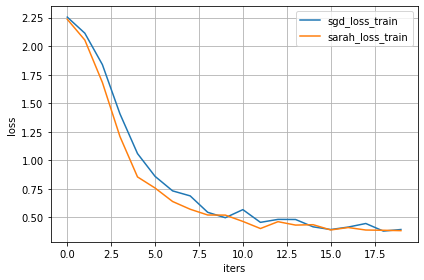

In [8]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_train,label='sgd_loss_train')
axs.plot(x,sarah_loss_train,label='sarah_loss_train')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('train_loss_sarah.pdf')

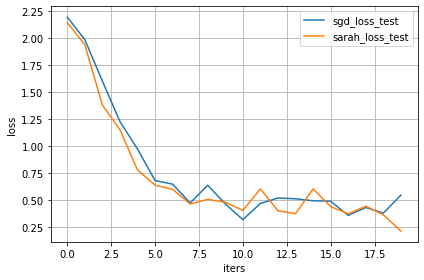

In [9]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_test,label='sgd_loss_test')
axs.plot(x,sarah_loss_test,label='sarah_loss_test')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('test_loss_sarah.pdf')

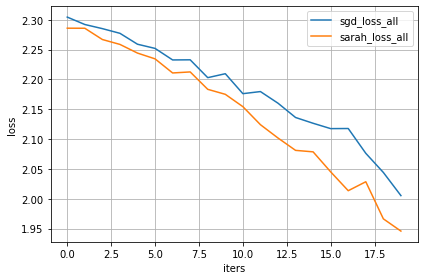

In [10]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_all[:EPOCH],label='sgd_loss_all')
axs.plot(x,sarah_loss_all[:EPOCH],label='sarah_loss_all')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('all_loss_sarah.pdf')

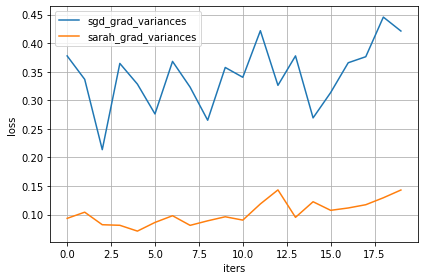

In [11]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_grad_variances[:EPOCH],label='sgd_grad_variances')
axs.plot(x,sarah_grad_variances[:EPOCH],label='sarah_grad_variances')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('grad_variances_sarah.pdf')